# Connect4 dataset viewer

This notebook documents the the dataset in `final_data/`:

- `<dataset>.npz`: dataset generated from dataset MCTS.

Each dataset contains:

- `boards`: 6x7 grid with +1 (to-move), -1 (opponent), 0 (empty)
- `X`: 6x7x2 encoding (channel 0 = to-move, channel 1 = opponent)
- `visits`: raw MCTS visit counts per column (length 7)
- `scores`: raw MCTS net scores per column (length 7)
- `policy`: normalized visits (length 7)
- `q`: per-move expected outcome (length 7)
- `value`: expected outcome for the board (length 1)

We will load the files, inspect shapes, show full examples with visual boards,
show how to mirror a dataset, and describe how to train and run a two-headed
policy/value CNN.


## Data sources (tunables)

Update these paths/URLs when your data moves (local file paths or GitHub release links).


In [1]:
from pathlib import Path
import urllib.request
import tempfile

# Data source can be a local path OR a direct URL to a .npz file.
DATASET_NPZ = "https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/mcts_not_mirrored_2000.npz"


def load_npz(source):
    # Load from local path or download URL to a temp file.
    if str(source).startswith("http://") or str(source).startswith("https://"):
        tmp_dir = Path(tempfile.gettempdir())
        tmp_path = tmp_dir / Path(str(source)).name
        if not tmp_path.exists():
            urllib.request.urlretrieve(str(source), tmp_path)
        return np.load(tmp_path)
    return np.load(Path(source))


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset using the tunable above.
npz = {
    "data": load_npz(DATASET_NPZ),
}
print("Loaded dataset:", DATASET_NPZ)


Loaded dataset: https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/mcts_not_mirrored_2000.npz


## Load the dataset

This block loads the two `.npz` files and stores them in a dictionary so we can
reference them consistently. We keep the paths explicit to avoid accidental
mixups.


## Quick dataset summary

This block prints the number of boards and the shapes of each stored array. It is
useful for confirming that all required fields are present and consistent.


In [3]:
data = npz["data"]
print("Dataset: data")
print("boards:", data["boards"].shape)
print("X:", data["X"].shape)
print("visits:", data["visits"].shape)
print("scores:", data["scores"].shape)
print("policy:", data["policy"].shape)
print("q:", data["q"].shape)
print("value:", data["value"].shape)


Dataset: data
boards: (703111, 6, 7)
X: (703111, 6, 7, 2)
visits: (703111, 7)
scores: (703111, 7)
policy: (703111, 7)
q: (703111, 7)
value: (703111, 1)


## Visualize a board

We render the 6x7 board so it is easy to see where the current player (+1) and
opponent (-1) pieces are. This is purely a visualization helper; it does not
change any data.


In [4]:
def plot_board(board, title=None):
    # Map: -1 (opponent) -> red, 0 -> white, +1 (to-move) -> blue.
    cmap = plt.cm.get_cmap("bwr", 3)
    plt.figure(figsize=(4, 3))
    plt.imshow(board, cmap=cmap, vmin=-1, vmax=1)
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.grid(True, color="black", linewidth=0.5)
    if title:
        plt.title(title)
    plt.show()


## Full random examples (three from each dataset)

This block prints **everything** for three random rows from each dataset:

- `board` (raw 6x7)
- `X` shape and channel sums
- `visits`, `scores`, `policy`, `q`, `value`
- A visual board plot

This is a sanity check that the data is internally consistent.


=== Random samples from data ===
Sample 1 (index 664373)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 1  0  0  1  0 -1  0]
 [ 1  0  0 -1  0  1  0]
 [-1  1  0 -1  0  1  0]
 [-1  1 -1 -1  0  1  0]]
X shape: (6, 7, 2)
X channel0 sum: 8.0 channel1 sum: 8.0
visits: [505. 516.  37. 318. 117. 238. 269.]
scores: [ 79.  82. -19.  30. -13.  10.  33.]
policy: [0.2525 0.258  0.0185 0.159  0.0585 0.119  0.1345]
q: [ 0.15643564  0.15891473 -0.5135135   0.09433962 -0.11111111  0.04201681
  0.12267658]
value: [0.101]


/tmp/ipython-input-490388798.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)


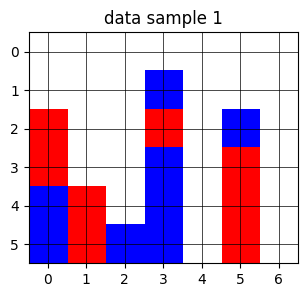

Sample 2 (index 439511)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1  0]
 [ 0 -1  0  1  0  1  0]
 [ 0 -1  0 -1 -1 -1  0]]
X shape: (6, 7, 2)
X channel0 sum: 4.0 channel1 sum: 5.0
visits: [0. 0. 0. 0. 0. 1. 0.]
scores: [0. 0. 0. 0. 0. 1. 0.]
policy: [0. 0. 0. 0. 0. 1. 0.]
q: [0. 0. 0. 0. 0. 1. 0.]
value: [1.]


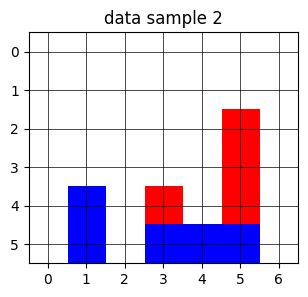

Sample 3 (index 481054)
board: [[-1  0  0  0 -1  0  0]
 [ 1  0  0  0  1  0  0]
 [ 1  0  0  0  1  0  0]
 [ 1  0  0  0 -1 -1  0]
 [-1  1  0  0 -1  1  0]
 [-1  1 -1 -1  1 -1  0]]
X shape: (6, 7, 2)
X channel0 sum: 9.0 channel1 sum: 10.0
visits: [  0. 623. 135. 627.   0. 542.  73.]
scores: [  0.  20. -25.  20.   0.   8. -29.]
policy: [0.     0.3115 0.0675 0.3135 0.     0.271  0.0365]
q: [ 0.          0.03210273 -0.18518518  0.03189792  0.          0.01476015
 -0.39726028]
value: [-0.003]


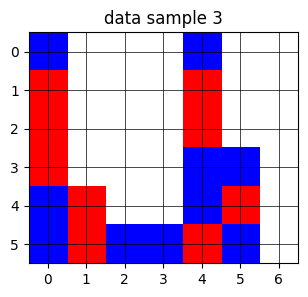

In [5]:
rng = np.random.default_rng(7)

data = npz["data"]
print("=== Random samples from data ===")
n = data["boards"].shape[0]
for i in range(3):
    idx = int(rng.integers(0, n))
    board = data["boards"][idx]
    X = data["X"][idx]
    visits = data["visits"][idx]
    scores = data["scores"][idx]
    policy = data["policy"][idx]
    q = data["q"][idx]
    value = data["value"][idx]

    print(f"Sample {i+1} (index {idx})")
    print("board:", board)
    print("X shape:", X.shape)
    print("X channel0 sum:", float(X[:, :, 0].sum()), "channel1 sum:", float(X[:, :, 1].sum()))
    print("visits:", visits)
    print("scores:", scores)
    print("policy:", policy)
    print("q:", q)
    print("value:", value)

    plot_board(board, title=f"data sample {i+1}")
